# Weekend Movie Trip

a project for EECS 731 by Benjamin Wyss

Examining MovieLens movie data to build a clustering model which can recommend movies similar to other movies

###### python imports

In [411]:
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
plt.close('all')
import warnings
warnings.filterwarnings('ignore')
import random as rand

### Reading Data Sets From CSV

MovieLens Small Datasets - Movies, Ratings, and Tags

Taken from: https://grouplens.org/datasets/movielens/ on 9/23/20

The small data sets were selected because they will reduce overall model complexity while still providing a sufficiently large number of samples (9742 movie samples)


###### Movies and Genres Data Set

In [412]:
movies = pd.read_csv('../data/raw/movies.csv')

In [413]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


###### User Ratings of Movies Data Set

In [414]:
ratings = pd.read_csv('../data/raw/ratings.csv')

In [415]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


###### User Tags of Movies Data Set

In [416]:
tags = pd.read_csv('../data/raw/tags.csv')

In [417]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


## The Big Ideas

Feature engineering and transformation can add value to these data sets for building a clustering model in the following ways:

(1): By extracting movie release years from movie titles and binning these years by decade, movies can be clustered together by similar time periods.

(2): By calculating the average user rating per movie, movies can be clustered according to similar ratings.

(3): By encoding a normalized count of the most popular user tags per movie, movies can be clustered according to similar combinations of user tags.

(4): By splitting the movie genres column into multiple columns corresponding to each genre, movies can be clustered according to similar combinations of genres.

## Exploratory Data Analysis

### Cleaning the data sets

In the ratings and tags data sets, the timestamp column is removed because it is related to the time at which users post reviews, not the movies that they review. Hence, this information will not aid the target clustering model.

Additionally, the userId column is dropped from the ratings and tags data sets because I will not be performing any per-user analysis. Rather, the target model will use average data across all users that will be calculated during data set transformation.

Moreover, in the movies and tags data sets, the tag and genres colums are converted to all lowercase letters. This will aid the encoding process because it will ensure that a tag like "heroic bloodshed" is counted the same as "Heroic Bloodshed". The same benefit applies to movie genres as well.

In [418]:
ratings = ratings[['movieId', 'rating']]

In [419]:
ratings

,movieId,rating
0,1,4.0
1,3,4.0
2,6,4.0
3,47,5.0
4,50,5.0
...,...,...
100831,166534,4.0
100832,168248,5.0
100833,168250,5.0
100834,168252,5.0


In [420]:
tags = tags[['movieId', 'tag']]
tags['tag'] = tags['tag'].str.lower()

In [421]:
tags

,movieId,tag
0,60756,funny
1,60756,highly quotable
2,60756,will ferrell
3,89774,boxing story
4,89774,mma
...,...,...
3678,7382,for katie
3679,7936,austere
3680,3265,gun fu
3681,3265,heroic bloodshed


In [422]:
movies['genres'] = movies['genres'].str.lower()

In [423]:
movies

,movieId,title,genres
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy
1,2,Jumanji (1995),adventure|children|fantasy
2,3,Grumpier Old Men (1995),comedy|romance
3,4,Waiting to Exhale (1995),comedy|drama|romance
4,5,Father of the Bride Part II (1995),comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy
9739,193585,Flint (2017),drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation


### Transforming the data sets


#### Extracting Release Year From Movie Title

Some movies have an extra space at the end of their title, which causes the year extraction slicing to grab the incorrect string slice. Other movies do not have a year listed, so I looked up and recorded their release year. These movies' years are updated manually so that the year column may be converted to an integer type

In [424]:
movies['year'] = movies['title'].str[-5:-1]

movies.loc[movies.year == '973)', 'year'] = '1973'
movies.loc[movies.year == '995)', 'year'] = '1995'
movies.loc[movies.year == '998)', 'year'] = '1998'
movies.loc[movies.year == '999)', 'year'] = '1999'
movies.loc[movies.year == '008)', 'year'] = '2008'
movies.loc[movies.year == '007)', 'year'] = '2007'
movies.loc[movies.year == '011)', 'year'] = '2011'
movies.loc[movies.year == '012)', 'year'] = '2012'
movies.loc[movies.year == '014)', 'year'] = '2014'

movies.loc[movies.year == 'lon ', 'year'] = '2007'
movies.loc[movies.year == 'r On', 'year'] = '2018'
movies.loc[movies.year == ' Roa', 'year'] = '2015'
movies.loc[movies.year == 'atso', 'year'] = '1980'
movies.loc[movies.year == 'imal', 'year'] = '2016'
movies.loc[movies.year == 'erso', 'year'] = '2016'
movies.loc[movies.year == 'ligh', 'year'] = '2016'
movies.loc[movies.year == 'he O', 'year'] = '2016'
movies.loc[movies.year == 'osmo', 'year'] = '2014'
movies.loc[movies.year == ' Bab', 'year'] = '2017'
movies.loc[movies.year == 'ron ', 'year'] = '2017'
movies.loc[movies.year == 'irro', 'year'] = '2011'

movies['year'] = movies['year'].astype('int32')


In [425]:
movies

,movieId,title,genres,year
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,1995
1,2,Jumanji (1995),adventure|children|fantasy,1995
2,3,Grumpier Old Men (1995),comedy|romance,1995
3,4,Waiting to Exhale (1995),comedy|drama|romance,1995
4,5,Father of the Bride Part II (1995),comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy,2017
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy,2017
9739,193585,Flint (2017),drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation,2018


###### Binning Movie Years by Decade

The movies data set has movies with release years ranging from 1902 to 2018. Hence, I will create bins which represent decades from the 1900s through the 2010s. Labels are selected so that a linear decade scale is created from 0 to 11, where 0 represents the 1900s and 11 represents the 2010s.

Additionally, once the decade bins have been determined, the year column is dropped from the data set so that the target classification model only sees the binned representation of the movie release year. This will aid the classification model because the binned data is more closely grouped together than the non-binned data.

In [426]:
bins = [1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
movies['decade'] = pd.cut(movies['year'], bins, labels=labels)
years = movies.pop('year')

In [427]:
movies

,movieId,title,genres,decade
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,9
1,2,Jumanji (1995),adventure|children|fantasy,9
2,3,Grumpier Old Men (1995),comedy|romance,9
3,4,Waiting to Exhale (1995),comedy|drama|romance,9
4,5,Father of the Bride Part II (1995),comedy,9
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy,11
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy,11
9739,193585,Flint (2017),drama,11
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation,11


###### Normalizing Movie Decades

To prevent distance-based clustering from being overly influenced by the large range of decade values, the decade column is normalized on a linear scale from 0 to 1 such that decade 0 corresponds to a value of 0 and decade 11 corresponds to a value of 1

In [428]:
movies['decade'] = movies['decade'].cat.codes / 11

In [429]:
movies

,movieId,title,genres,decade
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,0.818182
1,2,Jumanji (1995),adventure|children|fantasy,0.818182
2,3,Grumpier Old Men (1995),comedy|romance,0.818182
3,4,Waiting to Exhale (1995),comedy|drama|romance,0.818182
4,5,Father of the Bride Part II (1995),comedy,0.818182
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy,1.000000
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy,1.000000
9739,193585,Flint (2017),drama,1.000000
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation,1.000000


#### Calculating Average User Rating per Movie

Some movies have no user review data. These movies' average ratings are replaced with the mean value of all average ratings so that the target clustering model can reason about these movies as if they did have an average user rating.

In [430]:
for i in movies['movieId']:
    movies.loc[movies.movieId == i, 'averageRating'] = ratings[ratings.movieId == i].rating.mean()
    
movies['averageRating'] = movies['averageRating'].fillna(movies['averageRating'].mean())

In [431]:
movies

,movieId,title,genres,decade,averageRating
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,0.818182,3.920930
1,2,Jumanji (1995),adventure|children|fantasy,0.818182,3.431818
2,3,Grumpier Old Men (1995),comedy|romance,0.818182,3.259615
3,4,Waiting to Exhale (1995),comedy|drama|romance,0.818182,2.357143
4,5,Father of the Bride Part II (1995),comedy,0.818182,3.071429
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy,1.000000,4.000000
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy,1.000000,3.500000
9739,193585,Flint (2017),drama,1.000000,3.500000
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation,1.000000,3.500000


#### Calculating Most Popular User Tags per Movie

First, all listed movie tags are extracted from the tags data set, and then these tags are reduced to the list of tags that occur at least 5 times (184 tags meet this requirement). This will reduce the overall complexity of the target clustering model by reducing the total number of input features, and it will also aid the model because the model will not gain much value from clustering according to tags that occur very rarely.

In [432]:
allTags = tags['tag'].value_counts().head(184)

In [433]:
allTags

in netflix queue     131
atmospheric           41
superhero             24
thought-provoking     24
funny                 24
                    ... 
marriage               5
paranoia               5
poignant               5
dickens                5
homeless               5
Name: tag, Length: 184, dtype: int64

###### Converting Most Popular User Tags into Movie Attributes

Also, the total count of tags per movie is tracked so that tag counts can be later normalized

In [434]:
movies['totalTags'] = 0
for tag, count in allTags.items():
    for i in movies['movieId']:
        movies.loc[movies.movieId == i, ('tag_' + tag)] = ((tags.movieId == i) & (tags.tag == tag)).sum()
        movies.loc[movies.movieId == i, 'totalTags'] += movies.loc[movies.movieId == i, ('tag_' + tag)]

In [435]:
movies

,movieId,title,genres,decade,averageRating,totalTags,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,...,tag_biopic,tag_civil war,tag_organized crime,tag_baseball,tag_swashbuckler,tag_marriage,tag_paranoia,tag_poignant,tag_dickens,tag_homeless
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,0.818182,3.920930,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),adventure|children|fantasy,0.818182,3.431818,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),comedy|romance,0.818182,3.259615,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),comedy|drama|romance,0.818182,2.357143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),comedy,0.818182,3.071429,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy,1.000000,4.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy,1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9739,193585,Flint (2017),drama,1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation,1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### Normalizing Most Popular User Tags per Movie

Each movie's tag attributes are transformed to a value ranging from 0 to 1 which corresponds to the tag's percentage of the total tags for that movie. This normalization will allow movies that have only a few user tags to be compared with movies that have many user tags on a normalized scale. This will aid the target clustering model because it will reduce the variance in numbers of tags per movie.

To avoid dividing by 0, tags are normalized only when a movie has totalTags greater than 0. For a movie with no tags, each tag simply remains at the value 0, which represents no tags being associated with the movie.

Once all normalizations of tags are calculated, the totalTags column is dropped because it will not provide extra value to the target clustering model. This is because the model should not group movies based on how many tags they have, but rather what distribution of tags they have.

In [436]:
tagCols = [col for col in movies.columns if 'tag_' in col]
for col in tagCols:
    for i in movies['movieId']:
        if movies.loc[movies.movieId == i, 'totalTags'].all() != 0:
            movies.loc[movies.movieId == i, col] /= movies.loc[movies.movieId == i, 'totalTags']
totalTags = movies.pop('totalTags')

In [437]:
movies

,movieId,title,genres,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,...,tag_biopic,tag_civil war,tag_organized crime,tag_baseball,tag_swashbuckler,tag_marriage,tag_paranoia,tag_poignant,tag_dickens,tag_homeless
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,0.818182,3.920930,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),adventure|children|fantasy,0.818182,3.431818,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),comedy|romance,0.818182,3.259615,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),comedy|drama|romance,0.818182,2.357143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),comedy,0.818182,3.071429,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy,1.000000,4.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy,1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9739,193585,Flint (2017),drama,1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation,1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Column Splitting Movie Genres

In the movies data set, the genres column is split into multiple columns to obtain a numerical representation of each movie's genres. Additionally, column splitting ensures that each genre is treated as an independent attribute, which should aid the target clustering model in distinguishing between genre combinations.

###### Calculating All Recorded Movie Genres

In [438]:
allGenres = movies['genres'].str.split('|', expand=True).stack().value_counts()

In [439]:
allGenres

drama                 4361
comedy                3756
thriller              1894
action                1828
romance               1596
adventure             1263
crime                 1199
sci-fi                 980
horror                 978
fantasy                779
children               664
animation              611
mystery                573
documentary            440
war                    382
musical                334
western                167
imax                   158
film-noir               87
(no genres listed)      34
dtype: int64

###### Creating Columns for Each Genre and Splitting the Column

Once the genres have been split into multiple columns, the original genres column is dropped because the target clustering model will not gain any additional value from the strictly textual representation of this data

In [440]:
for genre, count in allGenres.items():
    movies['genre_' + genre] = movies['genres'].str.count(genre)
    
genres = movies.pop('genres')

In [441]:
movies

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_children,genre_animation,genre_mystery,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed)
0,1,Toy Story (1995),0.818182,3.920930,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0.818182,3.431818,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0.818182,3.259615,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),0.818182,2.357143,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0.818182,3.071429,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),1.000000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


### Exporting Processed Data Set to CSV File

In [442]:
movies.to_csv('../data/processed/movies_transformed.csv')

### Visualizing the Data

First, the processed data set is read in from its csv file. Some of the data transformation operations applied above are costly to run, and this ensures that those costly operations do not have to be run again as I create visualizations and models in this notebook. When reading in from the csv file, there is an extra Unnamed column which indicates row number. This column is not supposed to be in the data set and is thus dropped.

Next, some basic statistics of the data set and correlation coefficients are calculated

In [502]:
df = pd.read_csv('../data/processed/movies_transformed.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [444]:
df

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_children,genre_animation,genre_mystery,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed)
0,1,Toy Story (1995),0.818182,3.920930,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0.818182,3.431818,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0.818182,3.259615,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),0.818182,2.357143,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0.818182,3.071429,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),1.000000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),1.000000,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [445]:
df.describe()

,movieId,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,tag_sci-fi,...,genre_children,genre_animation,genre_mystery,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed)
count,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,...,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000
mean,42200.353623,0.819050,3.262448,0.012685,0.001302,0.001526,0.000484,0.001006,0.000770,0.000644,...,0.068158,0.062718,0.058817,0.045165,0.039212,0.034285,0.017142,0.016218,0.008930,0.003490
std,52160.494854,0.170316,0.869070,0.110551,0.027601,0.035748,0.012491,0.024652,0.021478,0.018860,...,0.252031,0.242468,0.235295,0.207677,0.194108,0.181968,0.129808,0.126321,0.094083,0.058976
min,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3248.250000,0.727273,2.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7300.000000,0.818182,3.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,76232.000000,0.909091,3.909091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,193609.000000,1.000000,5.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [446]:
df.corr()

,movieId,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,tag_sci-fi,...,genre_children,genre_animation,genre_mystery,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed)
movieId,1.000000,0.483539,0.027831,-0.070653,0.008775,-0.014760,0.013446,0.041028,0.016407,-0.007849,...,0.014081,0.165465,-0.011663,0.063766,-0.048694,-0.069510,-0.033304,0.083922,-0.050462,0.130199
decade,0.483539,1.000000,-0.108147,-0.086607,0.006484,0.005326,0.011946,0.030456,0.011964,0.009047,...,-0.009640,0.054502,-0.010356,0.087546,-0.087130,-0.143996,-0.095230,0.108659,-0.151914,0.033147
averageRating,0.027831,-0.108147,1.000000,0.072252,0.028709,-0.005336,0.024033,0.019764,0.031424,0.020753,...,-0.048163,0.069739,0.019537,0.129357,0.071692,0.007333,0.018379,0.007321,0.043545,0.007402
tag_in netflix queue,-0.070653,-0.086607,0.072252,1.000000,-0.004886,-0.004899,-0.004444,-0.004681,-0.003438,-0.003917,...,-0.023664,-0.012448,-0.007176,0.039879,0.005523,0.003895,0.006307,-0.007382,0.038458,-0.006791
tag_atmospheric,0.008775,0.006484,0.028709,-0.004886,1.000000,0.006310,0.041107,0.007581,0.034610,0.002943,...,-0.005375,0.014646,0.060233,-0.010257,-0.003140,-0.008886,0.010486,-0.006055,0.005407,-0.002791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
genre_musical,-0.069510,-0.143996,0.007333,0.003895,-0.008886,-0.008044,-0.007297,-0.007687,-0.006754,-0.006432,...,0.137072,0.111804,-0.035114,-0.005664,-0.032252,1.000000,0.018577,0.011536,-0.017886,-0.011151
genre_western,-0.033304,-0.095230,0.018379,0.006307,0.010486,-0.005638,-0.005114,-0.000041,-0.004734,-0.004508,...,-0.016890,-0.024378,-0.019570,-0.024915,0.014063,0.018577,1.000000,-0.004436,-0.004130,-0.007816
genre_imax,0.083922,0.108659,0.007321,-0.007382,-0.006055,0.041881,0.029883,-0.005238,0.009812,0.036144,...,0.062011,0.080744,-0.011374,0.003381,-0.009192,0.011536,-0.004436,1.000000,-0.012188,-0.007599
genre_film-noir,-0.050462,-0.151914,0.043545,0.038458,0.005407,-0.004053,-0.003676,-0.003872,-0.003403,-0.003240,...,-0.025673,-0.015555,0.087567,-0.020645,-0.019177,-0.017886,-0.004130,-0.012188,1.000000,-0.005618


###### Generating Interesting Plots

<AxesSubplot:title={'center':'Histogram of Average Movie Ratings'}, ylabel='Frequency'>

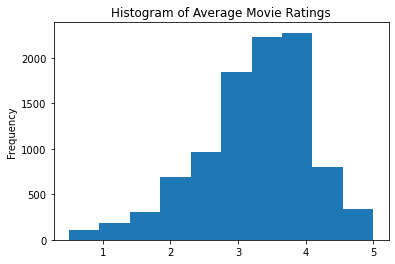

In [447]:
df['averageRating'].plot.hist(title='Histogram of Average Movie Ratings')

<AxesSubplot:title={'center':'Average Movie Rating vs. Movie Decade'}, xlabel='decade', ylabel='averageRating'>

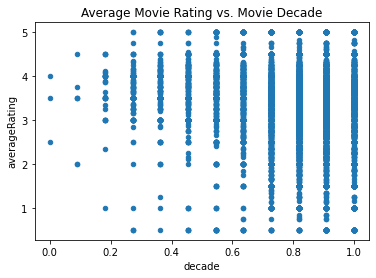

In [448]:
df.plot.scatter(x='decade', y='averageRating', title='Average Movie Rating vs. Movie Decade')

<AxesSubplot:title={'center':"Average Movie Rating vs. Movies Tagged in a User's Netflix Queue"}, xlabel='tag_in netflix queue', ylabel='averageRating'>

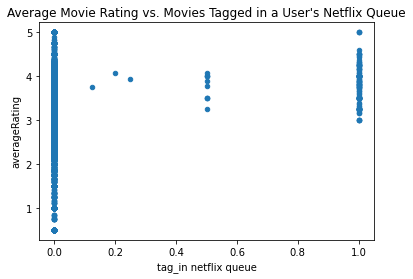

In [449]:
df.plot.scatter(x='tag_in netflix queue', y='averageRating', title='Average Movie Rating vs. Movies Tagged in a User\'s Netflix Queue')

<AxesSubplot:title={'center':'Average Movie Rating vs. Movies Listed in Documentary Genre'}, xlabel='genre_documentary', ylabel='averageRating'>

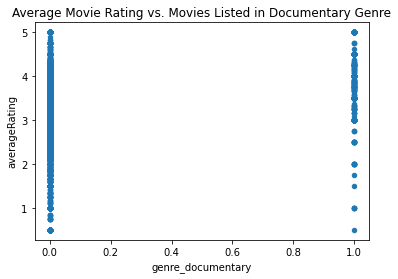

In [450]:
df.plot.scatter(x='genre_documentary', y='averageRating', title='Average Movie Rating vs. Movies Listed in Documentary Genre')

###### Intuitions Gained From Visualizations

It appears that many of the features in this dataset show some level of correlation. The target clustering model should be designed to account for dependencies of features.

### Model Construction

A variety of machine learning models will be tested and compared based on the clusters in which they place a set of test movies.

The models that will be tested are DBSCAN, MeanShift, and AgglomerativeClustering because each of these models takes a rather different approach to determining clusters. Because of this, each of these models should give some different resulting clusters that will be interesting to compare and contrast.

First, the pandas dataframe is converted to a numpy array, and the movieId and title columns are removed. This is because movieId is unrelated to the similarities between movies, and machine learning models cannot reason about the textual data in movie titles.

In [451]:
array = df.values
X = array[:, 2:]

#### DBSCAN Clustering

DBSCAN clusters are calculated and then appended to the original pandas dataframe for later testing and analysis. min_samples=3 was selected so that each movie has to have at least 2 other similar movies in order to form a cluster. eps=0.8 was selected by testing different eps values in order to minimize the number of samples deemed too noisy to assign to a cluster.

In [616]:
dbsModel = DBSCAN(eps=0.8, min_samples=2).fit(X)

In [617]:
dbsLabels = dbsModel.labels_

In [618]:
df['cluster_dbs'] = pd.Series(dbsLabels)

#### MeanShift Clustering

MeanShift clusters are calculated and then appended to the original pandas dataframe for later testing and analysis.

In [455]:
msModel = MeanShift().fit(X)

In [456]:
msLabels = msModel.labels_

In [504]:
df['cluster_ms'] = pd.Series(msLabels)

#### Agglomerative Clustering

Agglomerative clusters are calculated and then appended to the original pandas dataframe for later testing and analysis. distance_threshold=1.5 was selected by testing some different values in order to create clusters that don't have a very high number of movies

In [619]:
aggModel = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5).fit(X)

In [620]:
aggLabels = aggModel.labels_

In [621]:
df['cluster_agg'] = pd.Series(aggLabels)

### Analysis and Testing of Clustering Models

First, calculate the number of clusters that each model generates and the number of samples per cluster

###### Total Number of Clusters by Model

In [622]:
df.cluster_dbs.max()

513

In [623]:
df.cluster_ms.max()

1

In [624]:
df.cluster_agg.max()

1350

###### Total Number of Samples per Cluster by Model

In [625]:
df.cluster_dbs.value_counts()

-1      1184
 12     1000
 4       897
 38      410
 2       336
        ... 
 301       2
 309       2
 325       2
 333       2
 511       2
Name: cluster_dbs, Length: 515, dtype: int64

In [626]:
df.cluster_ms.value_counts()

0    9740
1       2
Name: cluster_ms, dtype: int64

In [648]:
df.cluster_agg.value_counts()

231     167
56      125
352     122
104     114
5       112
       ... 
866       1
858       1
1321      1
1265      1
1347      1
Name: cluster_agg, Length: 1351, dtype: int64

#### Eliminating the MeanShift Model

The MeanShift model is eliminated from testing because it only generated 2 clusters from the entire movie dataset of 9742 movies. A movie recommendation algorithm that recommends thousands of movies based on one liked movie is far too broad and will not be able to provide quality recommendations. Hence, the Meanshift model will not be tested or analyzed further.

#### Generate Cluster IDs for Test Movie Set

For the DBSCAN and Agglomerative models, I will examine the cluster in which they place the following set of test movies:

*God's Not Dead*, *Star Wars: Episode IV - A New Hope*, *Toy Story*, *Black Mirror*, and *Insidious*.

These movies were selected because I am familiar with these movies, and they draw from a variety of genres and time periods. While this test size is too small to gain a complete understanding of the performance of each model, it should provide some insights which will aid in analyzing some of the differences between the models.

In [628]:
dbsCluster1 = df.loc[df.movieId == 110603, 'cluster_dbs'].values[0]
dbsCluster2 = df.loc[df.movieId == 260, 'cluster_dbs'].values[0]
dbsCluster3 = df.loc[df.movieId == 1, 'cluster_dbs'].values[0]
dbsCluster4 = df.loc[df.movieId == 176601, 'cluster_dbs'].values[0]
dbsCluster5 = df.loc[df.movieId == 85788, 'cluster_dbs'].values[0]

aggCluster1 = df.loc[df.movieId == 110603, 'cluster_agg'].values[0]
aggCluster2 = df.loc[df.movieId == 260, 'cluster_agg'].values[0]
aggCluster3 = df.loc[df.movieId == 1, 'cluster_agg'].values[0]
aggCluster4 = df.loc[df.movieId == 176601, 'cluster_agg'].values[0]
aggCluster5 = df.loc[df.movieId == 85788, 'cluster_agg'].values[0]

###### God's Not Dead Clusters

The DBSCAN model creates a giant cluster which contains *God's Not Dead*, and it is very difficult to find similar movies within this large set. The agglomerative model, on the other hand, produces some similar and some dissimilar movies among a cluster which is made of very low rated movies.

In [629]:
df[df.cluster_dbs == dbsCluster1]

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed),cluster_dbs,cluster_ms,cluster_agg
13,14,Nixon (1995),0.818182,3.833333,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,167
25,26,Othello (1995),0.818182,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,226
36,40,"Cry, the Beloved Country (1995)",0.818182,4.250000,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,63
50,55,Georgia (1995),0.818182,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,56
51,57,Home for the Holidays (1995),0.818182,3.062500,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9656,180985,The Greatest Showman (2017),1.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,352
9672,182793,The Purple Sea (2009),0.909091,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,231
9727,190213,John From (2015),1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,658
9728,190215,Liquid Truth (2017),1.000000,1.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,1028


In [631]:
df[df.cluster_agg == aggCluster1]

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed),cluster_dbs,cluster_ms,cluster_agg
571,698,Delta of Venus (1995),0.818182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,658
874,1163,Mina Tannenbaum (1994),0.818182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,658
1156,1519,Broken English (1996),0.818182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,658
1659,2226,"Ring, The (1927)",0.181818,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,658
2088,2775,Head On (1998),0.818182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,658
2149,2862,Caligula (1979),0.636364,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,658
2229,2964,Julien Donkey-Boy (1999),0.818182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,658
5210,8494,"Cincinnati Kid, The (1965)",0.545455,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,658
5324,8840,Who's That Knocking at My Door? (1967),0.545455,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,658
7142,71438,Still Walking (Aruitemo aruitemo) (2008),0.909091,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,0,658


###### Star Wars: Episode IV - A New Hope Clusters

The DBSCAN model clusters *Star Wars: Episode IV - A New Hope* with a collection of 58 movies that are mostly science fiction and superhero movies, while the agglomerative model does a pretty good job at grouping *Star Wars: Episode IV - A New Hope* with other Star Wars movies.

In [632]:
df[df.cluster_dbs == dbsCluster2]

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed),cluster_dbs,cluster_ms,cluster_agg
176,208,Waterworld (1995),0.818182,2.913043,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,65
224,260,Star Wars: Episode IV - A New Hope (1977),0.636364,4.231076,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,314
385,442,Demolition Man (1993),0.818182,3.092593,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,65
898,1196,Star Wars: Episode V - The Empire Strikes Back...,0.727273,4.215640,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,314
1058,1375,Star Trek III: The Search for Spock (1984),0.727273,3.261905,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,65
1346,1831,Lost in Space (1998),0.818182,2.448276,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,184
1557,2094,"Rocketeer, The (1991)",0.818182,3.256410,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,65
1567,2105,Tron (1982),0.727273,3.340000,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,65
1692,2275,Six-String Samurai (1998),0.818182,3.600000,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,140
1904,2528,Logan's Run (1976),0.636364,3.229167,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,65


In [633]:
df[df.cluster_agg == aggCluster2]

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed),cluster_dbs,cluster_ms,cluster_agg
224,260,Star Wars: Episode IV - A New Hope (1977),0.636364,4.231076,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,314
898,1196,Star Wars: Episode V - The Empire Strikes Back...,0.727273,4.215640,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,314
911,1210,Star Wars: Episode VI - Return of the Jedi (1983),0.727273,4.137755,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,-1,0,314
5896,33493,Star Wars: Episode III - Revenge of the Sith (...,0.909091,3.429487,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,314
6863,62383,"20,000 Leagues Under the Sea (1916)",0.090909,3.750000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,73,0,314


###### Toy Story Clusters

The agglomerative model's cluster for *Toy Story* is a subset of the cluster produced by the DBSCAN model. While both models appear to do well at selecting movies that have very similar genres, the agglomerative model appears to select only the most similar of movies.

In [634]:
df[df.cluster_dbs == dbsCluster3]

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed),cluster_dbs,cluster_ms,cluster_agg
0,1,Toy Story (1995),0.818182,3.920930,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1210
1706,2294,Antz (1998),0.818182,3.244444,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,138
2355,3114,Toy Story 2 (1999),0.818182,3.860825,0.0,0.0,0.0,0.0,0.166667,0.0,...,0,0,0,0,0,0,0,0,0,1210
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",0.909091,2.222222,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,138
3000,4016,"Emperor's New Groove, The (2000)",0.909091,3.716216,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1210
3568,4886,"Monsters, Inc. (2001)",0.909091,3.871212,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1210
6194,45074,"Wild, The (2006)",0.909091,2.500000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,138
6486,53121,Shrek the Third (2007),0.909091,3.023810,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,138
6948,65577,"Tale of Despereaux, The (2008)",0.909091,3.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,138
8219,103755,Turbo (2013),1.000000,2.500000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,138


In [635]:
df[df.cluster_agg == aggCluster3]

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed),cluster_dbs,cluster_ms,cluster_agg
0,1,Toy Story (1995),0.818182,3.920930,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1210
2355,3114,Toy Story 2 (1999),0.818182,3.860825,0.0,0.0,0.0,0.0,0.166667,0.0,...,0,0,0,0,0,0,0,0,0,1210
3000,4016,"Emperor's New Groove, The (2000)",0.909091,3.716216,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1210
3568,4886,"Monsters, Inc. (2001)",0.909091,3.871212,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1210


###### Black Mirror Clusters

Each model produces strange clusters for *Black Mirror*. The DBSCAN model's cluster appears to have a very random distribution of movies, while the agglomerative model's cluster is composed of not too similar movies that have high ratings and similar decades.

In [636]:
df[df.cluster_dbs == dbsCluster4]

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed),cluster_dbs,cluster_ms,cluster_agg
8517,114335,La cravate (1957),0.454545,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,703
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,1.000000,3.785714,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,1215
8836,132084,Let It Be Me (1995),0.818182,2.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,471
8902,134861,Trevor Noah: African American (2013),1.000000,2.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,471
9033,141131,Guardians (2016),1.000000,2.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,471
9053,141866,Green Room (2015),1.000000,3.333333,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,703
9070,142456,The Brand New Testament (2015),1.000000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,1215
9091,143410,Hyena Road,1.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,471
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,0.727273,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,399
9178,149330,A Cosmic Christmas (1977),0.636364,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,1215


In [637]:
df[df.cluster_agg == aggCluster4]

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed),cluster_dbs,cluster_ms,cluster_agg
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,0.727273,5.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,399
9259,156605,Paterson,1.000000,4.50,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,-1,0,399
9307,159161,Ali Wong: Baby Cobra (2016),1.000000,4.50,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,399
9426,166024,Whiplash (2013),1.000000,4.75,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,399
9478,169034,Lemonade (2016),1.000000,4.50,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,399
9514,171495,Cosmos,1.000000,4.50,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,399
9518,171749,Death Note: Desu nôto (2006–2007),0.909091,5.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,399
9541,172591,The Godfather Trilogy: 1972-1990 (1992),0.818182,4.75,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,399
9562,173535,The Adventures of Sherlock Holmes and Doctor W...,0.727273,4.50,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,399
9611,176601,Black Mirror,1.000000,5.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,506,0,399


###### Insidious Clusters

Once again, the agglomerative model's cluster is a subset of the cluster produced by the DBSCAN model. Similarly to *Toy Story*, the agglomerative model is the more selective of the two models.

In [639]:
df[df.cluster_dbs == dbsCluster5]

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed),cluster_dbs,cluster_ms,cluster_agg
1732,2327,Tales from the Darkside: The Movie (1990),0.818182,3.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,286,0,724
4961,7561,Paperhouse (1988),0.727273,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,286,0,724
6195,45081,Silent Hill (2006),0.909091,2.958333,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,286,0,1104
7569,85788,Insidious (2010),1.000000,2.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,286,0,1104
8682,122884,Insidious: Chapter 3 (2015),1.000000,2.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,286,0,1104


In [640]:
df[df.cluster_agg == aggCluster5]

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_superhero,tag_thought-provoking,tag_funny,tag_surreal,...,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed),cluster_dbs,cluster_ms,cluster_agg
6195,45081,Silent Hill (2006),0.909091,2.958333,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,286,0,1104
7569,85788,Insidious (2010),1.000000,2.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,286,0,1104
8682,122884,Insidious: Chapter 3 (2015),1.000000,2.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,286,0,1104


### Results

Out of all of the models examined, I would recommend utilizing the agglomerative model's clusters for movie recommendations. The MeanShift model simply did not generate enough clusters to provide meaningful recommendations. In comparing the remaining models, the agglomerative model outperformed the DBSCAN model in the following ways:

(1): The DBSCAN model failed to generate clusters with at least 2 movies for 1184 movies, while the agglomerative model only failed to form clusters with at least 2 movies for 115 movies.

(2): In general, the agglomerative model's clusters were more selective, having fewer, more high quality recommendations than the DBSCAN model. In particular, some of the DBSCAN model's clusters contained up to 1000 movies, while the largest agglomerative model cluster contained 167 movies. 167 movies is likely still too broad to provide high quality movie recommendations, but it is certainly more refined than 1000 movies.

For these reasons, the agglomerative model's clusters will be used in exporting the final data set.

#### Exporting the Movie Data Set with Recommendation Clusters to CSV

The data set's columns are trimmed to only the most relevant and easy to read data and then sorted by cluster before writing to a csv file.

In [649]:
df = df[['title', 'averageRating', 'cluster_agg']].sort_values(by=['cluster_agg'])

In [650]:
df

,title,averageRating,cluster_agg
2093,Cat's Eye (1985),2.416667,0
1583,Children of the Corn (1984),2.454545,0
1894,Christine (1983),2.950000,0
1582,Cujo (1983),2.214286,0
1601,Legend (1985),3.076923,1
...,...,...,...
5418,Captains Courageous (1937),4.000000,1350
2388,Easy Rider (1969),3.603448,1350
4926,"Ten Commandments, The (1956)",3.750000,1350
1410,Mutiny on the Bounty (1935),4.166667,1350


In [651]:
df.to_csv('../data/processed/movie_clusters.csv')